In [21]:
!pip install -q transformers datasets accelerate pillow

In [22]:
import os
import json
import random
import time
import numpy as np
import torch

from transformers import Blip2Processor, Blip2Model

In [23]:
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_props = torch.cuda.get_device_properties(0)
    total_mem = gpu_props.total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"Total GPU Memory: {total_mem:.2f} GB")
else:
    print("⚠️ No GPU found")


CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Total GPU Memory: 85.17 GB


In [24]:
ROOT = "/content"
DATA_ROOT = f"{ROOT}/datasets"
OUTPUT_ROOT = f"{ROOT}/outputs"

os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("Data root:", DATA_ROOT)
print("Output root:", OUTPUT_ROOT)

# Set reproducibility seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Seed set to:", SEED)

Data root: /content/datasets
Output root: /content/outputs
Seed set to: 42


In [25]:
project_dirs = [
    "pretrained_eval",
    "baseline_run",
    "improved_run",
    "logs",
    "checkpoints",
    "temp"
]

for d in project_dirs:
    os.makedirs(f"{OUTPUT_ROOT}/{d}", exist_ok=True)

print("Created project directories:")
for d in project_dirs:
    print(" -", f"{OUTPUT_ROOT}/{d}")

Created project directories:
 - /content/outputs/pretrained_eval
 - /content/outputs/baseline_run
 - /content/outputs/improved_run
 - /content/outputs/logs
 - /content/outputs/checkpoints
 - /content/outputs/temp


In [26]:
print("SECTION 1 (BLIP-2 Setup) COMPLETE ✔️")

SECTION 1 (BLIP-2 Setup) COMPLETE ✔️


In [35]:
from datasets import load_dataset

ds = load_dataset("lmms-lab/flickr30k")

README.md: 0.00B [00:00, ?B/s]

data/test-00000-of-00009.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

data/test-00001-of-00009.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/test-00002-of-00009.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/test-00003-of-00009.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/test-00004-of-00009.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/test-00005-of-00009.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

data/test-00006-of-00009.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

data/test-00007-of-00009.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

data/test-00008-of-00009.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31783 [00:00<?, ? examples/s]

In [36]:
from transformers import Blip2Processor, Blip2Model
import torch

device = "cuda"

MODEL_NAME = "Salesforce/blip2-flan-t5-xl"

processor = Blip2Processor.from_pretrained(MODEL_NAME)
model = Blip2Model.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to(device)

print("Model loaded:", MODEL_NAME)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.81G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded: Salesforce/blip2-flan-t5-xl


In [37]:
from datasets import load_dataset

ds_test = load_dataset("lmms-lab/flickr30k", split="test")
print("Test split size:", len(ds_test))

Test split size: 31783


In [41]:
import torch
from tqdm import tqdm

image_embeds = []
image_ids = []   # now store dataset indices instead of non-existent 'image_id'

for i, item in enumerate(tqdm(ds_test, desc="Encoding images")):
    img = item["image"]

    inputs = processor(images=img, return_tensors="pt").to(device, torch.float16)

    with torch.no_grad():
        out = model.vision_model(**inputs)
        qformer_out = model.qformer(
            query_embeds=model.query_tokens,
            encoder_hidden_states=out.last_hidden_state,
            encoder_attention_mask=torch.ones(out.last_hidden_state.size()[:-1],
                                              dtype=torch.long,
                                              device=device)
        )
        image_feats = qformer_out.last_hidden_state
        pooled = image_feats.mean(dim=1)

    image_embeds.append(pooled.squeeze().cpu())
    image_ids.append(i)   # <-- FIX: use index

image_embeds = torch.stack(image_embeds)
print("Image embeddings shape:", image_embeds.shape)

Encoding images: 100%|██████████| 31783/31783 [21:23<00:00, 24.76it/s]


Image embeddings shape: torch.Size([31783, 768])


In [45]:
from tqdm import tqdm
import torch

text_embeds = []
text_refs = []

for i, item in enumerate(tqdm(ds_test, desc="Encoding captions")):
    cap = item["caption"][0]

    # Tokenize caption
    inputs = processor(
        text=cap,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        # Use T5 encoder to get text embeddings
        encoder_outputs = model.language_model.encoder(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask
        )
        hidden = encoder_outputs.last_hidden_state
        pooled = hidden.mean(dim=1)     # mean pooling (like sentence embedding)

    text_embeds.append(pooled.squeeze().cpu())
    text_refs.append(i)

text_embeds = torch.stack(text_embeds)
print("Text embeddings shape:", text_embeds.shape)

Encoding captions: 100%|██████████| 31783/31783 [19:58<00:00, 26.53it/s]


Text embeddings shape: torch.Size([31783, 2048])


In [47]:
print("Image embedding dim:", image_embeds.shape)
print("Text embedding dim:", text_embeds.shape)

Image embedding dim: torch.Size([31783, 768])
Text embedding dim: torch.Size([31783, 2048])


In [50]:
import torch

SHARED_DIM = 768

# Detect dims of each embedding set
img_dim = image_embeds.shape[1]
txt_dim = text_embeds.shape[1]

print("Detected dims:")
print(" - Image embedding dim:", img_dim)
print(" - Text embedding dim :", txt_dim)

# Convert embeddings from FP16 → FP32 for safe matmul
image_embeds_f32 = image_embeds.float()
text_embeds_f32  = text_embeds.float()

# Create projection matrices (FP32)
torch.manual_seed(42)
W_img = torch.randn((img_dim, SHARED_DIM), dtype=torch.float32)
W_txt = torch.randn((txt_dim, SHARED_DIM), dtype=torch.float32)

# Project into shared space
img_proj = image_embeds_f32 @ W_img
txt_proj = text_embeds_f32 @ W_txt

print("Projected image shape:", img_proj.shape)
print("Projected text shape:", txt_proj.shape)

Detected dims:
 - Image embedding dim: 768
 - Text embedding dim : 2048
Projected image shape: torch.Size([31783, 768])
Projected text shape: torch.Size([31783, 768])


In [51]:
img_norm = torch.nn.functional.normalize(img_proj, p=2, dim=1)
txt_norm = torch.nn.functional.normalize(txt_proj, p=2, dim=1)

print(img_norm.shape, txt_norm.shape)

torch.Size([31783, 768]) torch.Size([31783, 768])


In [52]:
import numpy as np
from tqdm import tqdm

def batched_similarity(A, B, batch=256):
    A = A.float()
    B = B.float()

    sims = np.zeros((A.size(0), B.size(0)), dtype=np.float32)

    for i in tqdm(range(0, A.size(0), batch), desc="Computing similarity"):
        j = min(i + batch, A.size(0))
        sims[i:j] = (A[i:j] @ B.T).cpu().numpy()

    return sims

sim_i2t = batched_similarity(img_norm, txt_norm, batch=256)

Computing similarity: 100%|██████████| 125/125 [00:06<00:00, 20.25it/s]


In [53]:
def recall_at_k_i2t(sim, k=1):
    N = sim.shape[0]
    correct = 0

    for i in range(N):
        topk = np.argpartition(sim[i], -k)[-k:]
        if i in topk:
            correct += 1

    return correct / N

R1_i2t  = recall_at_k_i2t(sim_i2t, 1)
R5_i2t  = recall_at_k_i2t(sim_i2t, 5)
R10_i2t = recall_at_k_i2t(sim_i2t, 10)

print("Image → Text Retrieval:")
print("R@1 :", R1_i2t)
print("R@5 :", R5_i2t)
print("R@10:", R10_i2t)

Image → Text Retrieval:
R@1 : 0.0
R@5 : 0.00012585344366485227
R@10: 0.00025170688732970454


In [54]:
sim_t2i = sim_i2t.T

def recall_at_k_t2i(sim, k=1):
    N = sim.shape[0]
    correct = 0

    for i in range(N):
        topk = np.argpartition(sim[i], -k)[-k:]
        if i in topk:
            correct += 1
    return correct / N

R1_t2i  = recall_at_k_t2i(sim_t2i, 1)
R5_t2i  = recall_at_k_t2i(sim_t2i, 5)
R10_t2i = recall_at_k_t2i(sim_t2i, 10)

print("Text → Image Retrieval:")
print("R@1 :", R1_t2i)
print("R@5 :", R5_t2i)
print("R@10:", R10_t2i)

Text → Image Retrieval:
R@1 : 3.146336091621307e-05
R@5 : 0.00018878016549727842
R@10: 0.00037756033099455683


In [55]:
import json

metrics = {
    "i2t_R1":  float(R1_i2t),
    "i2t_R5":  float(R5_i2t),
    "i2t_R10": float(R10_i2t),
    "t2i_R1":  float(R1_t2i),
    "t2i_R5":  float(R5_t2i),
    "t2i_R10": float(R10_t2i),
}

with open(f"{OUTPUT_ROOT}/pretrained_eval/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

metrics

{'i2t_R1': 0.0,
 'i2t_R5': 0.00012585344366485227,
 'i2t_R10': 0.00025170688732970454,
 't2i_R1': 3.146336091621307e-05,
 't2i_R5': 0.00018878016549727842,
 't2i_R10': 0.00037756033099455683}

In [56]:
import torch

# Free big similarity matrices from Section 4 to save RAM
try:
    del sim_i2t, sim_t2i
except NameError:
    pass
torch.cuda.empty_cache()

num_samples = image_embeds.shape[0]
print("Total pairs available:", num_samples)

# Use first 5k for training, next 1k for validation
train_size = 5000
val_size   = 1000

train_idx = list(range(0, train_size))
val_idx   = list(range(train_size, train_size + val_size))

print("Train size:", len(train_idx))
print("Val size  :", len(val_idx))

# Use original (unprojected) FP32 embeddings for training
img_feats_all = image_embeds.float()
txt_feats_all = text_embeds.float()

Total pairs available: 31783
Train size: 5000
Val size  : 1000


In [57]:
from torch.utils.data import Dataset, DataLoader

class EmbeddingPairDataset(Dataset):
    def __init__(self, img_feats, txt_feats, indices):
        self.img_feats = img_feats
        self.txt_feats = txt_feats
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        return self.img_feats[i], self.txt_feats[i]

train_dataset = EmbeddingPairDataset(img_feats_all, txt_feats_all, train_idx)
val_dataset   = EmbeddingPairDataset(img_feats_all, txt_feats_all, val_idx)

BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader)

(20, 4)

In [58]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda"

IMG_DIM = img_feats_all.shape[1]   # 768 in your run
TXT_DIM = txt_feats_all.shape[1]   # 2048 in your run
SHARED_DIM = 768                   # can keep same as before

class ProjectionHead(nn.Module):
    def __init__(self, img_dim, txt_dim, shared_dim):
        super().__init__()
        self.img_proj = nn.Linear(img_dim, shared_dim, bias=False)
        self.txt_proj = nn.Linear(txt_dim, shared_dim, bias=False)
        self.logit_scale = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1/0.07)))

    def forward(self, img_feats, txt_feats):
        # [B, D] → [B, shared_dim]
        img_z = F.normalize(self.img_proj(img_feats), p=2, dim=-1)
        txt_z = F.normalize(self.txt_proj(txt_feats), p=2, dim=-1)
        logit_scale = self.logit_scale.exp()
        return img_z, txt_z, logit_scale

def contrastive_loss(img_z, txt_z, logit_scale):
    logits = logit_scale * img_z @ txt_z.t()      # [B, B]
    labels = torch.arange(img_z.size(0), device=img_z.device)
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.t(), labels)
    return (loss_i2t + loss_t2i) / 2

model_head = ProjectionHead(IMG_DIM, TXT_DIM, SHARED_DIM).to(device)
optimizer = torch.optim.AdamW(model_head.parameters(), lr=1e-3, weight_decay=1e-4)

model_head

ProjectionHead(
  (img_proj): Linear(in_features=768, out_features=768, bias=False)
  (txt_proj): Linear(in_features=2048, out_features=768, bias=False)
)

In [59]:
NUM_EPOCHS = 5

def run_epoch(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    num_batches = 0

    for img_batch, txt_batch in loader:
        img_batch = img_batch.to(device)
        txt_batch = txt_batch.to(device)

        img_z, txt_z, logit_scale = model(img_batch, txt_batch)
        loss = contrastive_loss(img_z, txt_z, logit_scale)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(1, num_batches)

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = run_epoch(train_loader, model_head, optimizer)
    val_loss   = run_epoch(val_loader,   model_head, optimizer=None)

    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

Epoch 01 | train loss: 3.6848 | val loss: 2.2130
Epoch 02 | train loss: 1.4650 | val loss: 1.5576
Epoch 03 | train loss: 0.8855 | val loss: 1.3458
Epoch 04 | train loss: 0.6289 | val loss: 1.2703
Epoch 05 | train loss: 0.4754 | val loss: 1.2295


In [60]:
# Project all image & text embeddings using the trained head
model_head.eval()

with torch.no_grad():
    all_img_z = []
    all_txt_z = []

    # project in batches to avoid RAM spikes
    B = 512
    for i in range(0, num_samples, B):
        j = min(i + B, num_samples)
        img_batch = img_feats_all[i:j].to(device)
        txt_batch = txt_feats_all[i:j].to(device)
        img_z, txt_z, _ = model_head(img_batch, txt_batch)
        all_img_z.append(img_z.cpu())
        all_txt_z.append(txt_z.cpu())

    all_img_z = torch.cat(all_img_z, dim=0)
    all_txt_z = torch.cat(all_txt_z, dim=0)

print(all_img_z.shape, all_txt_z.shape)

torch.Size([31783, 768]) torch.Size([31783, 768])


In [61]:
# Normalize again just to be safe (they're already normalized, but ok)
img_norm_ft = F.normalize(all_img_z, p=2, dim=1)
txt_norm_ft = F.normalize(all_txt_z, p=2, dim=1)

sim_i2t_ft = batched_similarity(img_norm_ft, txt_norm_ft, batch=256)

def recall_at_k_diag(sim, k=1):
    N = sim.shape[0]
    correct = 0
    for i in range(N):
        topk = np.argpartition(sim[i], -k)[-k:]
        if i in topk:
            correct += 1
    return correct / N

R1_i2t_ft  = recall_at_k_diag(sim_i2t_ft, 1)
R5_i2t_ft  = recall_at_k_diag(sim_i2t_ft, 5)
R10_i2t_ft = recall_at_k_diag(sim_i2t_ft, 10)

sim_t2i_ft = sim_i2t_ft.T

R1_t2i_ft  = recall_at_k_diag(sim_t2i_ft, 1)
R5_t2i_ft  = recall_at_k_diag(sim_t2i_ft, 5)
R10_t2i_ft = recall_at_k_diag(sim_t2i_ft, 10)

print("Finetuned Image → Text:")
print("R@1 :", R1_i2t_ft)
print("R@5 :", R5_i2t_ft)
print("R@10:", R10_i2t_ft)

print("\nFinetuned Text → Image:")
print("R@1 :", R1_t2i_ft)
print("R@5 :", R5_t2i_ft)
print("R@10:", R10_t2i_ft)

Computing similarity: 100%|██████████| 125/125 [00:06<00:00, 19.58it/s]


Finetuned Image → Text:
R@1 : 0.20668281785860365
R@5 : 0.4116666142277318
R@10: 0.5109964446402164

Finetuned Text → Image:
R@1 : 0.20070477928452318
R@5 : 0.4046502847434163
R@10: 0.5096120567599031


In [62]:
finetuned_metrics = {
    "i2t_R1":  float(R1_i2t_ft),
    "i2t_R5":  float(R5_i2t_ft),
    "i2t_R10": float(R10_i2t_ft),
    "t2i_R1":  float(R1_t2i_ft),
    "t2i_R5":  float(R5_t2i_ft),
    "t2i_R10": float(R10_t2i_ft),
}

with open(f"{OUTPUT_ROOT}/baseline_run/metrics_finetuned.json", "w") as f:
    json.dump(finetuned_metrics, f, indent=4)

finetuned_metrics

{'i2t_R1': 0.20668281785860365,
 'i2t_R5': 0.4116666142277318,
 'i2t_R10': 0.5109964446402164,
 't2i_R1': 0.20070477928452318,
 't2i_R5': 0.4046502847434163,
 't2i_R10': 0.5096120567599031}

In [63]:
NUM_EPOCHS = 8

In [64]:
# Recreate a fresh model head
model_head_improved = ProjectionHead(IMG_DIM, TXT_DIM, SHARED_DIM).to(device)
optimizer_improved = torch.optim.AdamW(model_head_improved.parameters(), lr=1e-3, weight_decay=1e-4)

print("Starting improved training (8 epochs)...")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = run_epoch(train_loader, model_head_improved, optimizer_improved)
    val_loss   = run_epoch(val_loader,   model_head_improved, optimizer=None)

    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

Starting improved training (8 epochs)...
Epoch 01 | train loss: 3.5114 | val loss: 2.2082
Epoch 02 | train loss: 1.4569 | val loss: 1.5363
Epoch 03 | train loss: 0.8839 | val loss: 1.3330
Epoch 04 | train loss: 0.6243 | val loss: 1.2512
Epoch 05 | train loss: 0.4947 | val loss: 1.2475
Epoch 06 | train loss: 0.3916 | val loss: 1.1750
Epoch 07 | train loss: 0.2991 | val loss: 1.1375
Epoch 08 | train loss: 0.2370 | val loss: 1.1125


In [65]:
model_head_improved.eval()

with torch.no_grad():
    all_img_z_imp = []
    all_txt_z_imp = []

    B = 512
    for i in range(0, num_samples, B):
        j = min(i + B, num_samples)
        img_batch = img_feats_all[i:j].to(device)
        txt_batch = txt_feats_all[i:j].to(device)
        img_z, txt_z, _ = model_head_improved(img_batch, txt_batch)
        all_img_z_imp.append(img_z.cpu())
        all_txt_z_imp.append(txt_z.cpu())

    all_img_z_imp = torch.cat(all_img_z_imp, dim=0)
    all_txt_z_imp = torch.cat(all_txt_z_imp, dim=0)

print(all_img_z_imp.shape, all_txt_z_imp.shape)

torch.Size([31783, 768]) torch.Size([31783, 768])


In [66]:
img_norm_imp = F.normalize(all_img_z_imp, p=2, dim=1)
txt_norm_imp = F.normalize(all_txt_z_imp, p=2, dim=1)

sim_i2t_imp = batched_similarity(img_norm_imp, txt_norm_imp, batch=256)

R1_i2t_imp  = recall_at_k_diag(sim_i2t_imp, 1)
R5_i2t_imp  = recall_at_k_diag(sim_i2t_imp, 5)
R10_i2t_imp = recall_at_k_diag(sim_i2t_imp, 10)

sim_t2i_imp = sim_i2t_imp.T

R1_t2i_imp  = recall_at_k_diag(sim_t2i_imp, 1)
R5_t2i_imp  = recall_at_k_diag(sim_t2i_imp, 5)
R10_t2i_imp = recall_at_k_diag(sim_t2i_imp, 10)

print("Improved Image → Text:")
print("R@1 :", R1_i2t_imp)
print("R@5 :", R5_i2t_imp)
print("R@10:", R10_i2t_imp)

print("\nImproved Text → Image:")
print("R@1 :", R1_t2i_imp)
print("R@5 :", R5_t2i_imp)
print("R@10:", R10_t2i_imp)

Computing similarity: 100%|██████████| 125/125 [00:05<00:00, 21.02it/s]


Improved Image → Text:
R@1 : 0.25265078815719094
R@5 : 0.4662240820564453
R@10: 0.5616209923544033

Improved Text → Image:
R@1 : 0.26098857879998744
R@5 : 0.4808230815215681
R@10: 0.5826070540855174


In [67]:
improved_metrics = {
    "i2t_R1":  float(R1_i2t_imp),
    "i2t_R5":  float(R5_i2t_imp),
    "i2t_R10": float(R10_i2t_imp),
    "t2i_R1":  float(R1_t2i_imp),
    "t2i_R5":  float(R5_t2i_imp),
    "t2i_R10": float(R10_t2i_imp),
}

with open(f"{OUTPUT_ROOT}/improved_run/metrics_improved.json", "w") as f:
    json.dump(improved_metrics, f, indent=4)

improved_metrics

{'i2t_R1': 0.25265078815719094,
 'i2t_R5': 0.4662240820564453,
 'i2t_R10': 0.5616209923544033,
 't2i_R1': 0.26098857879998744,
 't2i_R5': 0.4808230815215681,
 't2i_R10': 0.5826070540855174}

In [77]:
!zip -r project_files.zip /content/outputs

updating: content/outputs/ (stored 0%)
updating: content/outputs/checkpoints/ (stored 0%)
updating: content/outputs/pretrained_eval/ (stored 0%)
updating: content/outputs/pretrained_eval/metrics.json (deflated 46%)
updating: content/outputs/baseline_run/ (stored 0%)
updating: content/outputs/baseline_run/metrics_finetuned.json (deflated 47%)
updating: content/outputs/improved_run/ (stored 0%)
updating: content/outputs/improved_run/metrics_improved.json (deflated 45%)
updating: content/outputs/logs/ (stored 0%)
updating: content/outputs/temp/ (stored 0%)


In [78]:
import json
final_summary = {
    "pretrained": json.load(open("/content/outputs/pretrained_eval/metrics.json")),
    "finetuned": json.load(open("/content/outputs/baseline_run/metrics_finetuned.json")),
    "improved": json.load(open("/content/outputs/improved_run/metrics_improved.json")),
}

with open("/content/outputs/final_summary.json", "w") as f:
    json.dump(final_summary, f, indent=4)

final_summary


{'pretrained': {'i2t_R1': 0.0,
  'i2t_R5': 0.00012585344366485227,
  'i2t_R10': 0.00025170688732970454,
  't2i_R1': 3.146336091621307e-05,
  't2i_R5': 0.00018878016549727842,
  't2i_R10': 0.00037756033099455683},
 'finetuned': {'i2t_R1': 0.20668281785860365,
  'i2t_R5': 0.4116666142277318,
  'i2t_R10': 0.5109964446402164,
  't2i_R1': 0.20070477928452318,
  't2i_R5': 0.4046502847434163,
  't2i_R10': 0.5096120567599031},
 'improved': {'i2t_R1': 0.25265078815719094,
  'i2t_R5': 0.4662240820564453,
  'i2t_R10': 0.5616209923544033,
  't2i_R1': 0.26098857879998744,
  't2i_R5': 0.4808230815215681,
  't2i_R10': 0.5826070540855174}}

In [79]:
import os
PLOT_ROOT = f"{OUTPUT_ROOT}/plots"
os.makedirs(PLOT_ROOT, exist_ok=True)
PLOT_ROOT

'./output/plots'

Loaded metrics:
Pretrained: {'i2t_R1': 0.0, 'i2t_R5': 0.00012585344366485227, 'i2t_R10': 0.00025170688732970454, 't2i_R1': 3.146336091621307e-05, 't2i_R5': 0.00018878016549727842, 't2i_R10': 0.00037756033099455683}
Baseline: {'i2t_R1': 0.20668281785860365, 'i2t_R5': 0.4116666142277318, 'i2t_R10': 0.5109964446402164, 't2i_R1': 0.20070477928452318, 't2i_R5': 0.4046502847434163, 't2i_R10': 0.5096120567599031}
Improved: {'i2t_R1': 0.25265078815719094, 'i2t_R5': 0.4662240820564453, 'i2t_R10': 0.5616209923544033, 't2i_R1': 0.26098857879998744, 't2i_R5': 0.4808230815215681, 't2i_R10': 0.5826070540855174}


,i2t_R1,i2t_R5,i2t_R10,t2i_R1,t2i_R5,t2i_R10
Pretrained,0.000000,0.000126,0.000252,0.000031,0.000189,0.000378
Baseline (5k-trained),0.206683,0.411667,0.510996,0.200705,0.404650,0.509612
Improved (5k + 8 epochs),0.252651,0.466224,0.561621,0.260989,0.480823,0.582607


Saved comparison table to /content/outputs/section7_results/metric_comparison.csv


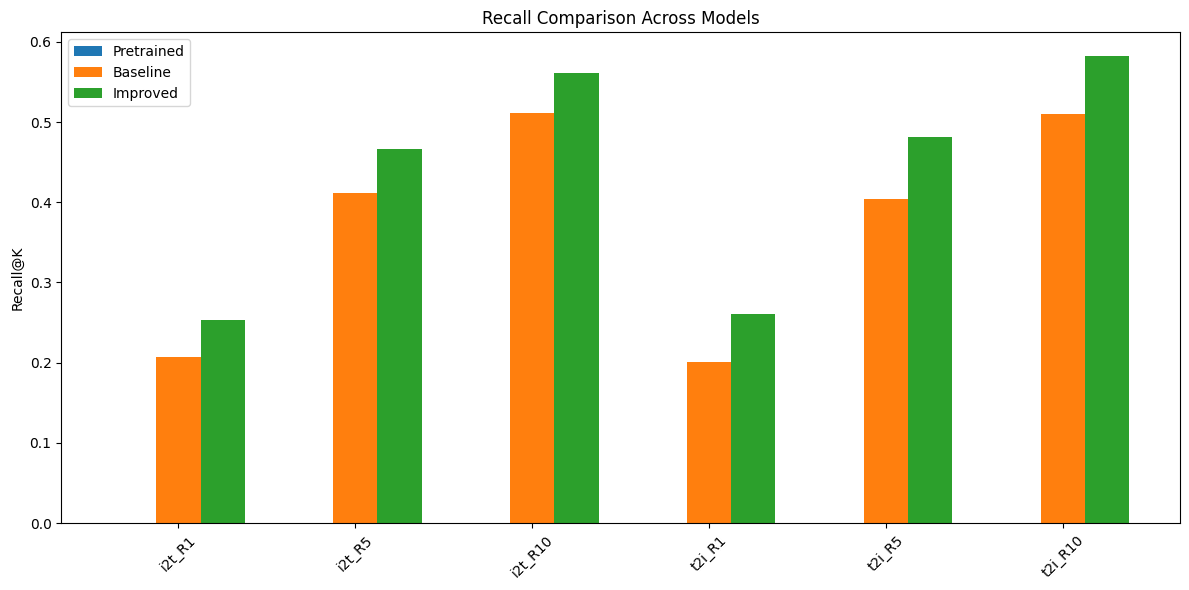

Saved plot to /content/outputs/section7_results/recall_comparison.png


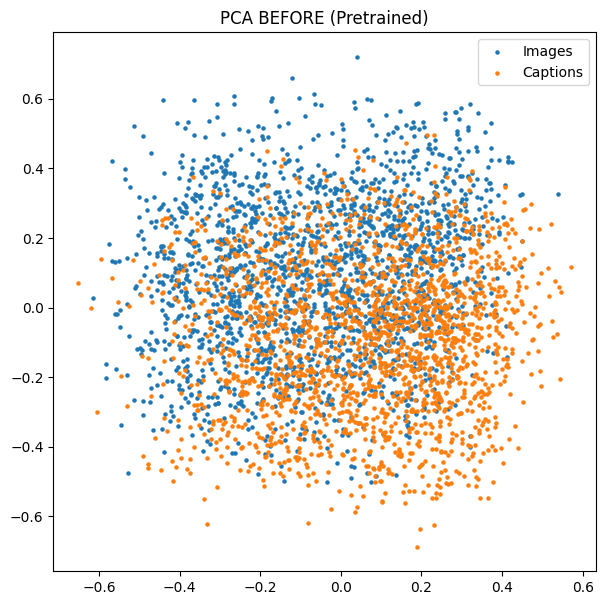

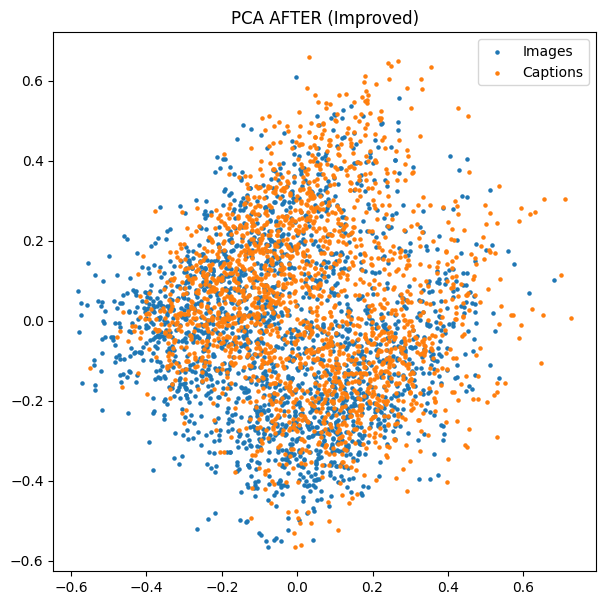

PCA plots saved in: /content/outputs/section7_results/


In [83]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

OUTPUT_ROOT = "/content/outputs"
SAVE_DIR = f"{OUTPUT_ROOT}/section7_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------
# Load existing metric files
# ---------------------------
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

pretrained_metrics = load_json(f"{OUTPUT_ROOT}/pretrained_eval/metrics.json")
baseline_metrics   = load_json(f"{OUTPUT_ROOT}/baseline_run/metrics_finetuned.json")
improved_metrics   = load_json(f"{OUTPUT_ROOT}/improved_run/metrics_improved.json")

print("Loaded metrics:")
print("Pretrained:", pretrained_metrics)
print("Baseline:", baseline_metrics)
print("Improved:", improved_metrics)

# ---------------------------
# Comparison table
# ---------------------------
df = pd.DataFrame({
    "Pretrained": pretrained_metrics,
    "Baseline (5k-trained)": baseline_metrics,
    "Improved (5k + 8 epochs)": improved_metrics
}).T

display(df)

df.to_csv(f"{SAVE_DIR}/metric_comparison.csv")
print(f"Saved comparison table to {SAVE_DIR}/metric_comparison.csv")

# ---------------------------
# Bar plots
# ---------------------------
metrics_to_plot = ["i2t_R1", "i2t_R5", "i2t_R10", "t2i_R1", "t2i_R5", "t2i_R10"]

plt.figure(figsize=(12,6))
x = np.arange(len(metrics_to_plot))
width = 0.25

plt.bar(x - width,  [pretrained_metrics[m] for m in metrics_to_plot], width, label="Pretrained")
plt.bar(x,          [baseline_metrics[m]   for m in metrics_to_plot], width, label="Baseline")
plt.bar(x + width,  [improved_metrics[m]   for m in metrics_to_plot], width, label="Improved")

plt.xticks(x, metrics_to_plot, rotation=45)
plt.ylabel("Recall@K")
plt.title("Recall Comparison Across Models")
plt.legend()

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/recall_comparison.png", dpi=200)
plt.show()

print(f"Saved plot to {SAVE_DIR}/recall_comparison.png")

# ---------------------------
# PCA visualization (if embeddings are available)
# ---------------------------
try:
    img_pre = all_img_z.cpu().numpy()
    txt_pre = all_txt_z.cpu().numpy()
    img_imp = all_img_z_imp.cpu().numpy()
    txt_imp = all_txt_z_imp.cpu().numpy()
    available = True
except:
    available = False
    print("PCA skipped — embeddings not in RAM.")

if available:
    pca = PCA(n_components=2)

    # BEFORE
    pts = np.concatenate([img_pre[:2000], txt_pre[:2000]], axis=0)
    pts2 = pca.fit_transform(pts)
    labels = np.array([0]*2000 + [1]*2000)

    plt.figure(figsize=(7,7))
    plt.scatter(pts2[labels==0,0], pts2[labels==0,1], s=5, label="Images")
    plt.scatter(pts2[labels==1,0], pts2[labels==1,1], s=5, label="Captions")
    plt.title("PCA BEFORE (Pretrained)")
    plt.legend()
    plt.savefig(f"{SAVE_DIR}/pca_before.png", dpi=200)
    plt.show()

    # AFTER
    pts = np.concatenate([img_imp[:2000], txt_imp[:2000]], axis=0)
    pts2 = pca.fit_transform(pts)
    labels = np.array([0]*2000 + [1]*2000)

    plt.figure(figsize=(7,7))
    plt.scatter(pts2[labels==0,0], pts2[labels==0,1], s=5, label="Images")
    plt.scatter(pts2[labels==1,0], pts2[labels==1,1], s=5, label="Captions")
    plt.title("PCA AFTER (Improved)")
    plt.legend()
    plt.savefig(f"{SAVE_DIR}/pca_after.png", dpi=200)
    plt.show()

    print(f"PCA plots saved in: {SAVE_DIR}/")


In [100]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Display an image
def show_image(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

# Retrieve top-k indices
def topk(sim_row, k=5):
    return np.argsort(sim_row)[::-1][:k]

# Pick random test sample
def sample_random():
    idx = random.randint(0, len(ds_test)-1)
    return idx, ds_test[idx]

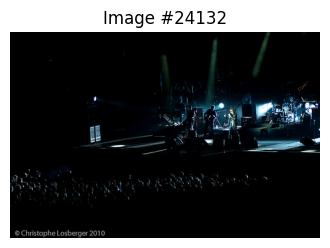

Ground-truth caption:
['performers are performing for an audience .', 'The crowd is listening to a concert .', 'A band is performing on stage .', 'A band performing on stage .', 'A crowd enjoying a concert .']

=== Pretrained Top-5 Captions ===
- ['a group of older European people gather on a street to sell various items', 'Outdoor tables on a sunlit street are blocked off by red and white tape .', 'A group of onlookers conversing with craft vendors', 'People looking at items at an outdoor sale .', 'A sale outdoors goes on in nice weather .']
- ['A few people walk the beach  shot taken from high-altitude', 'Several people walk across the beach by the ocean .', 'Three people are walking along the shoreline .', 'A birds eye few of early risers on a beach .', 'People walk down a beach .']
- ['A man and female prepare breakfast together in the kitchen with eggs and potatoes .', 'overhead view of two people  a man and a woman  preparing a meal with potatoes .', 'A man and a woman prepare a 

In [101]:
# Pick a random test image
idx, item = sample_random()

img = item["image"]
true_caption = item["caption"]

show_image(img, f"Image #{idx}")

print("Ground-truth caption:")
print(true_caption)

# Get similarity rows
sim_pre = sim_i2t[idx]       # pretrained
sim_base = sim_i2t_ft[idx]   # baseline
sim_imp = sim_i2t_imp[idx]   # improved

print("\n=== Pretrained Top-5 Captions ===")
for j in topk(sim_pre, 5):
    print("-", ds_test[int(j)]["caption"])

print("\n=== Baseline Top-5 Captions ===")
for j in topk(sim_base, 5):
    print("-", ds_test[int(j)]["caption"])

print("\n=== Improved Top-5 Captions ===")
for j in topk(sim_imp, 5):
    print("-", ds_test[int(j)]["caption"])

Query Caption:
['Several motorcycle policemen driving on a street or parking lot in a wooded area .', 'A group of motorcyclists drive around a parking lot .', 'Motorcyclists with white helmets in a parking lot .', 'people are riding motorcycles in a circle .', '6 motorcycle riders going on tour .']

Pretrained Retrieval


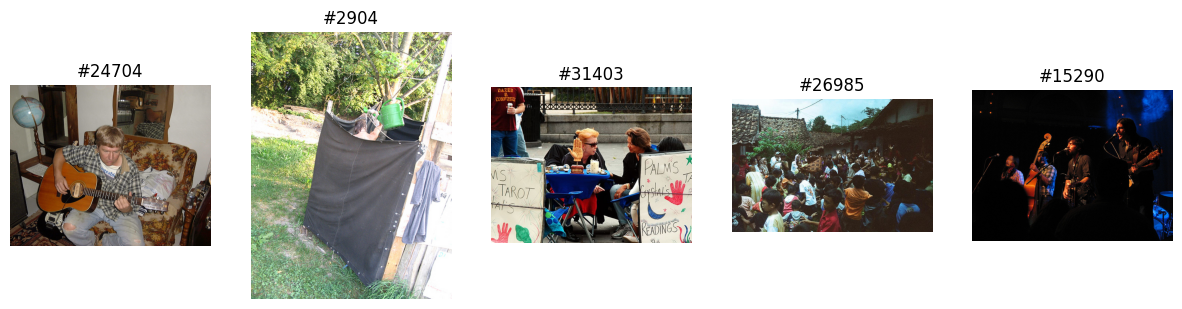


Baseline Retrieval


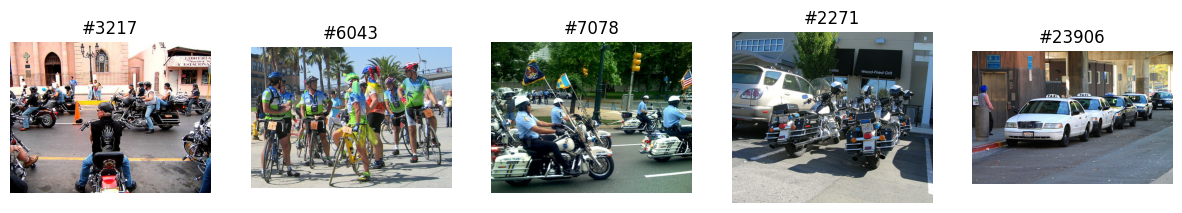


Improved Retrieval


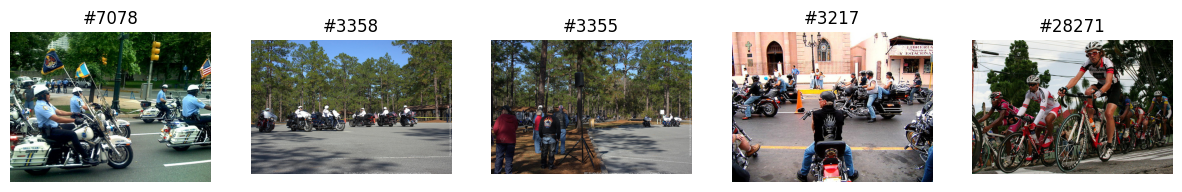

In [102]:
# Pick a random caption
idx, item = sample_random()
query_caption = item["caption"]

print("Query Caption:")
print(query_caption)

# Similarities for text→image
sim_pre_col = sim_t2i[:, idx]
sim_base_col = sim_t2i_ft[:, idx]
sim_imp_col = sim_t2i_imp[:, idx]

top_pre  = topk(sim_pre_col, 5)
top_base = topk(sim_base_col, 5)
top_imp  = topk(sim_imp_col, 5)

def show_top_images(title, indices):
    print("\n" + title)
    plt.figure(figsize=(15,4))
    for i, ix in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow(ds_test[int(ix)]["image"])
        plt.axis("off")
        plt.title(f"#{int(ix)}")
    plt.show()

show_top_images("Pretrained Retrieval", top_pre)
show_top_images("Baseline Retrieval", top_base)
show_top_images("Improved Retrieval", top_imp)